In [5]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from pytz import timezone

In [6]:
data = pd.read_excel('BizOps_Sample Data.xlsx')

In [7]:
data.head()

,Customer placed order datetime,Placed order with restaurant datetime,Driver at restaurant datetime,Delivered to consumer datetime,Driver ID,Restaurant ID,Consumer ID,Is New,Delivery Region,Is ASAP,Order total,Amount of discount,Amount of tip,Refunded amount
0,14 20:27:45,14 20:29:41,14 20:39:32,14 20:52:03,86,12,5,False,Palo Alto,True,20.45,20.45,3.07,0.0
1,07 20:16:28,07 20:17:32,07 20:36:00,07 20:49:02,325,66,5,False,Palo Alto,True,40.62,40.62,3.73,0.0
2,13 19:35:09,13 19:39:26,13 20:28:16,13 20:52:44,200,124,5,False,Palo Alto,True,37.78,37.78,1.89,0.0
3,22 19:47:53,22 19:56:08,22 20:01:20,22 20:18:01,154,5,14,False,Palo Alto,True,39.66,0.00,1.98,0.0
4,03 19:01:52,03 19:09:08,03 19:36:20,03 19:45:26,332,9,14,False,Palo Alto,True,39.66,0.00,5.95,0.0


In [8]:
data.shape

(18078, 14)

In [9]:
data.dtypes

Customer placed order datetime            object
Placed order with restaurant datetime     object
Driver at restaurant datetime             object
Delivered to consumer datetime            object
Driver ID                                  int64
Restaurant ID                              int64
Consumer ID                                int64
Is New                                      bool
Delivery Region                           object
Is ASAP                                     bool
Order total                              float64
Amount of discount                       float64
Amount of tip                            float64
Refunded amount                          float64
dtype: object

In [10]:
#convert datetime variables from string to datetime format, and from UTC to PDT
data['order_datetime'] = pd.to_datetime(data['Customer placed order datetime'], format="%d %H:%M:%S", utc=True) + timedelta(hours=6)
data['receive_by_restaurant'] = pd.to_datetime(data['Placed order with restaurant datetime'], format="%d %H:%M:%S", utc=True) + timedelta(hours=6)
data['driver_at_restaurant'] = pd.to_datetime(data['Driver at restaurant datetime'], format="%d %H:%M:%S", utc=True) + timedelta(hours=6)
data['deliver_datetime'] = pd.to_datetime(data['Delivered to consumer datetime'], format="%d %H:%M:%S", utc=True) + timedelta(hours=6)

In [11]:
#set order_datetime as the datetimeIndex of data
data = data.set_index(pd.DatetimeIndex(data['order_datetime']))

#### Missing values discussion

In [12]:
#check missing value
data.isnull().sum()

Customer placed order datetime              0
Placed order with restaurant datetime      40
Driver at restaurant datetime            4531
Delivered to consumer datetime              0
Driver ID                                   0
Restaurant ID                               0
Consumer ID                                 0
Is New                                      0
Delivery Region                             0
Is ASAP                                     0
Order total                                 0
Amount of discount                          0
Amount of tip                               0
Refunded amount                             0
order_datetime                              0
receive_by_restaurant                      40
driver_at_restaurant                     4531
deliver_datetime                            0
dtype: int64

40 missing values in "Placed order with restaurant datetime". To investigate what has happened, it would be interesting know if these orders were delivered to customer - 1) Did the driver show up? 2) What was the delivered to customer datetime? 3) Was there refund associated?

In [13]:
missing_receive_by_rest = data.loc[data['receive_by_restaurant'].isnull()]

In [14]:
#waiting time = deliver_datetime - order_datetime
missing_receive_by_rest['lead_time'] = (missing_receive_by_rest['deliver_datetime'] - missing_receive_by_rest['order_datetime']).astype('timedelta64[m]') 
print ("Consumers received thier orders between {} and {} minutes".format(missing_receive_by_rest['lead_time'].min(), missing_receive_by_rest['lead_time'].max()))
#how many drivers showed up
print ("Number of drivers showed up: {}".format(40 - missing_receive_by_rest['Driver at restaurant datetime'].isnull().sum()))
#refund percentage
ratio = missing_receive_by_rest['Refunded amount'].sum() / missing_receive_by_rest['Order total'].sum()
print ("Refund ratio: {0:.2f}%".format(ratio*100))

Consumers received thier orders between 30.0 and 3747.0 minutes
Number of drivers showed up: 23
Refund ratio: 0.06%


/Users/jinghao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Among the 40 transactions that missing the "receive_by_restaurant" datetime, all of them were delivered with a positive lead time between 30 minutes to less than 3 days; at least 23 orders got delivered by drivers; and the refund ratio was as low as 0.06%. We can conclude that even with these missing data, the orders were still fulfilled.

Now let's look at the 4531 records with missing values of "driver_at_restaurant".It's very possible that the customer came to restaurant and picked up the order. But to confirm, we need to answer the same questions above.

In [15]:
missing_drivers = data.loc[data['driver_at_restaurant'].isnull()]

In [16]:
#waiting time = deliver_datetime - order_datetime
missing_drivers['lead_time'] = (missing_receive_by_rest['deliver_datetime'] - missing_receive_by_rest['order_datetime']).astype('timedelta64[m]') 
print ("Consumers received thier orders between {} and {} minutes".format(missing_drivers['lead_time'].min(), missing_drivers['lead_time'].max()))
#refund percentage
ratio = missing_drivers['Refunded amount'].sum() / missing_drivers['Order total'].sum()
print ("Refund ratio: {0:.2f}%".format(ratio*100))

Consumers received thier orders between 49.0 and 1209.0 minutes
Refund ratio: 1.54%


/Users/jinghao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


total restaurants: 274
total orders (4531) fulfilled by top 20 restaurants: 1811


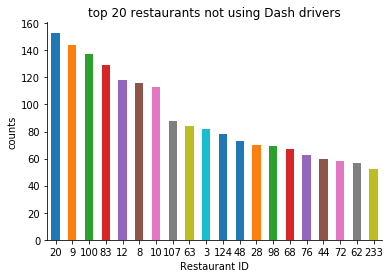

In [17]:
print('total restaurants: {}'.format(missing_drivers['Restaurant ID'].value_counts().shape[0]))
print('total orders (4531) fulfilled by top 20 restaurants: {}'.format(missing_drivers['Restaurant ID'].value_counts().head(20).sum()))
fig = plt.figure()
ax = fig.add_subplot(111)
missing_drivers['Restaurant ID'].value_counts().head(20).plot(kind='bar')
plt.title('top 20 restaurants not using Dash drivers')
plt.ylabel('counts')
plt.xlabel('Restaurant ID')
plt.xticks(rotation='horizontal')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

All the orders got delivered with from 49 minutes to 20 hours of lead time; the refund ratio was as low as 1.54%. The following bar plot shows the restaurants with the most transactions. Out of 4531 order with missing "driver_at_restaurant" datetime data, the top 20 restaurants completed 1811 orders. As these transactions have high density on some restaurants, it could be that these restaurants offer straight deliveries, or in the areas that consumers would like to pick up, or not parking friendly for drivers. To answer this, we can further explore the location and traffic of these restaurants.

One suggestion here for the desigh of system is that if we can get special timestamp codes based on differenct situations: the customer picked up the food, or the restaurant delivered the food, or the driver missed the deliery, or the system missed the message, etc. That would help a lot in understanding what happened here. But back to the concerns to the missing values, they should not affect my analysis futher.

In [18]:
#check the data range and possible outliers
data.describe()

,Driver ID,Restaurant ID,Consumer ID,Order total,Amount of discount,Amount of tip,Refunded amount
count,18078.000000,18078.000000,18078.000000,18078.000000,18078.000000,18078.000000,18078.000000
mean,222.448169,108.721263,32010.313475,51.261496,1.356706,3.492022,0.612091
std,105.219194,98.609766,42010.215766,50.599675,6.516667,3.700115,6.073104
min,7.000000,2.000000,5.000000,0.000000,0.000000,0.000000,0.000000
25%,141.000000,23.000000,4243.500000,26.660000,0.000000,1.400000,0.000000
50%,227.000000,77.000000,10972.000000,38.630000,0.000000,2.550000,0.000000
75%,314.000000,186.000000,56857.000000,57.885000,0.000000,4.460000,0.000000
max,438.000000,409.000000,200449.000000,1604.130000,187.880000,120.300000,414.770000


No obvious outliers found.

#### Data stories

Text(0,0.5,'dashes')

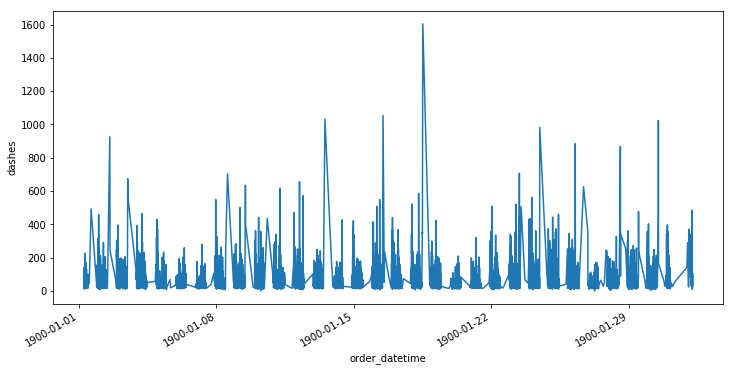

In [19]:
data['Order total'].plot(figsize=(12,6))
plt.ylabel('dashes')

The overall transactions is steay within the month. With the pattern that every five days of relatively high values followed by two days of low values, we can roughly conclude that weekays have more orders than weekends. Within each day, it also shows peak hours. Could there be any mid-night orders? It would be an interesting question to answer if we limit the plot scope to less days and get a magnification of hourly pattern.

As I'm more interested in improving the business and drive market growth, I'm going to look at the sales summary.

/Users/jinghao/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


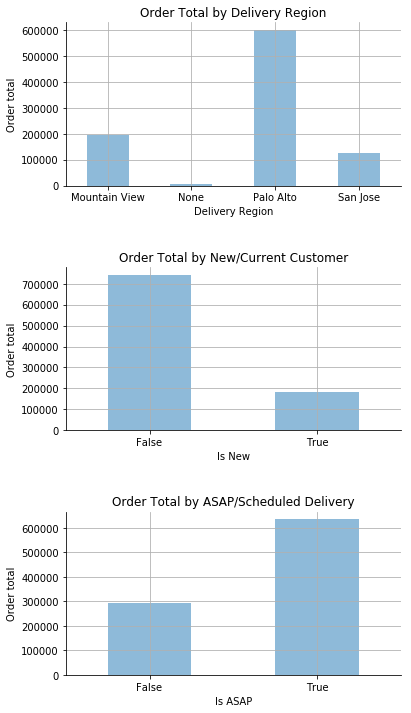

In [20]:
fig = plt.figure(figsize=(6,12))
ax1 = fig.add_subplot(3, 1, 1)
data.groupby(by=data['Delivery Region']).sum()['Order total'].plot(kind='bar', grid=True, colors = '#1f77b4', alpha=0.5)
plt.ylabel('Order total')
plt.title('Order Total by Delivery Region')
plt.xticks(rotation='horizontal')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax1 = fig.add_subplot(3, 1, 2)
data.groupby(by=data['Is New']).sum()['Order total'].plot(kind='bar', grid=True, colors = '#1f77b4', alpha=0.5)
plt.ylabel('Order total')
plt.title('Order Total by New/Current Customer')
plt.xticks(rotation='horizontal')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax1 = fig.add_subplot(3, 1, 3)
data.groupby(by=data['Is ASAP']).sum()['Order total'].plot(kind='bar', grid=True, colors = '#1f77b4', alpha=0.5)
plt.ylabel('Order total')
plt.title('Order Total by ASAP/Scheduled Delivery')
plt.xticks(rotation='horizontal')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

plt.subplots_adjust(hspace=0.5)

Current cutomers drive as three times of revenue as the new cutomers. San Jose area has the largest population and land but only drives less than three time of sales in Palo Alto. My suggession for attacting new cutomers is to target San Jose area. 

Now let's take a closer look of current vs new cutomers, see what we can to with improving retention rate and growth.

In [21]:
#group the data by new/current customers.
grouped = data.groupby(by=data['Is New'])

/Users/jinghao/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


Text(0,0.5,'dashes')

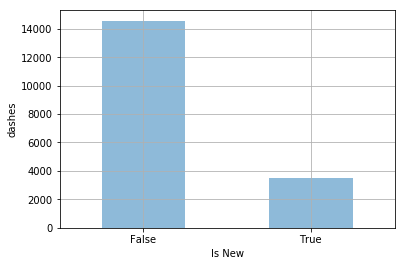

In [22]:
grouped.size().plot(kind='bar',grid=True, colors = '#1f77b4', alpha=0.5)
plt.xticks(rotation='horizontal')
plt.ylabel("dashes")

Do they show regional difference?

/Users/jinghao/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


Text(0.5,1,'Current Customers')

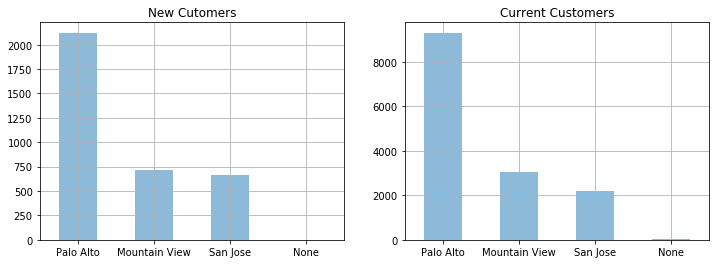

In [23]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(1,2,1)
# plt.bar(data.loc[data['Is New'] == True]['Delivery Region'].value_counts())
data.loc[data['Is New'] == True]['Delivery Region'].value_counts().plot(kind='bar',grid=True, colors = '#1f77b4', alpha=0.5)
plt.xticks(rotation='horizontal')
plt.title("New Cutomers")

ax2 = fig.add_subplot(1,2,2)
data.loc[data['Is New'] == False]['Delivery Region'].value_counts().plot(kind='bar',grid=True, colors = '#1f77b4', alpha=0.5)
plt.xticks(rotation='horizontal')
plt.title("Current Customers")

Looks like no.

Who is more satisfied?

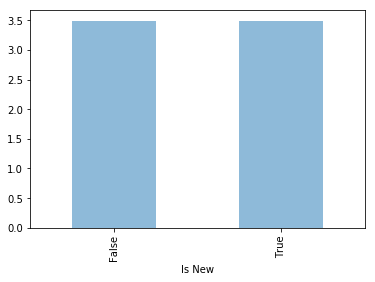

In [24]:
grouped.mean()['Amount of tip'].plot(kind='bar', color='#1f77b4', alpha=0.5)

The average tip amount is almost the same.

Who is more unsatisfied?

In [25]:
new_cutomer_unsatisfaction = data.loc[(data['Refunded amount'] > 0) & (data['Is New'] == True)].shape[0] / data.loc[data['Is New'] == True].shape[0]
current_cutomer_unsatisfaction = data.loc[(data['Refunded amount'] > 0) & (data['Is New'] == False)].shape[0] / data.loc[data['Is New'] == False].shape[0]
print ("{0:.2f}% of new cutomers asked for refunds.".format(new_cutomer_unsatisfaction * 100))
print ("{0:.2f}% of current cutomers asked for refunds.".format(current_cutomer_unsatisfaction * 100))

2.88% of new cutomers asked for refunds.
2.71% of current cutomers asked for refunds.


Around the same... 

As we noticed more revenues were driven by ASAP orders. Would be interested to know who are using on-scheduled orders.

/Users/jinghao/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


Text(0.5,1,'Current Customers')

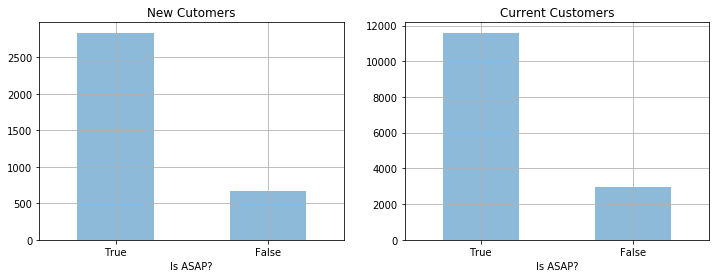

In [26]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(1,2,1)
# plt.bar(data.loc[data['Is New'] == True]['Delivery Region'].value_counts())
data.loc[data['Is New'] == True]['Is ASAP'].value_counts().plot(kind='bar',grid=True, colors = '#1f77b4', alpha=0.5)
plt.xticks(rotation='horizontal')
plt.xlabel("Is ASAP?")
plt.title("New Cutomers")

ax2 = fig.add_subplot(1,2,2)
data.loc[data['Is New'] == False]['Is ASAP'].value_counts().plot(kind='bar',grid=True, colors = '#1f77b4', alpha=0.5)
plt.xticks(rotation='horizontal')
plt.xlabel("Is ASAP?")
plt.title("Current Customers")

New and current cutomers seem to have the same attitude towards ASAP and on-schedule orders.

Now it comes to the question does the promotion work? Was the promotion targed to new customer? 

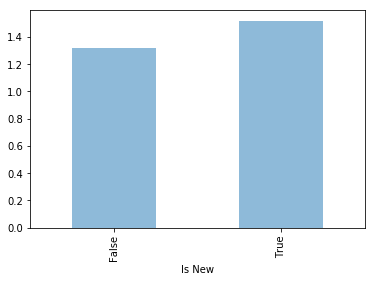

In [27]:
grouped.mean()['Amount of discount'].plot(kind='bar', color='#1f77b4', alpha=0.5)

We can test if average amount of discount is the same between new and current customers.

In [28]:
mean_discount_new = data.loc[data['Is New'] == True]['Amount of discount'].mean()
mean_discount_current = data.loc[data['Is New'] == False]['Amount of discount'].mean()
print ("average discounts receved by new cutomers: {}".format(mean_discount_new))
print ("average discounts receved by current cutomers: {}".format(mean_discount_current))

average discounts receved by new cutomers: 1.5186389521640091
average discounts receved by current cutomers: 1.3176630509405463


In [29]:
print("effect size: {}".format(mean_discount_new - mean_discount_current))

effect size: 0.20097590122346287


Null Hypothesis: Mean discounts aren't significantly different.

Hypothese: Mean discounts are signicantly different.

Perform t-test and determine the p-value.

p-value is the probability that the effective size was by chance. If it's less than alpha, meaning there's only a small chance you would have obtained the data if the null hypothesis is true, then we can reject the null. In our case, it means the promotion is differented between new customers and current cutomers. 

Otherwise, it means the promotion to new customers and exist customers are not dignificantly different, I would suggest to give more promotion on first-time customer orders, which could potentially drive growth of the new customers.

*One extra step for performing statistical tests is that we need to further process the missing values. Since here we did not discuss about the restaurant's response time or driver's logistic time, we can drop "Placed order with restaurant datetime" and "Driver at restaurant datetime" columns. That would avoid the missing values.

A limitation of this approach is that to check the effectiveness we should look into new customers' growth rate, which I would like to discuss in my future analysis.

If my hypothesis (average discounts to new customers and current custoemrs are different) was true, one of the challenges when we scale up the promotion is that our sample here is biased towards the bay area, the promotion works in one group may not work in another, thus we should consider more factors and make promotions more sensitive to the targeted market. 

The promotion should be differentiated among different delivery regions. In this example, the promotion targeted to San Jose area may drive growth.

If on-scheduled delivery will help optimize the operations and logistic efficiency, the promotion should be preferred to on-scheduled order.

We can do A/B test on different strategies and check on customer growth rate.
